In [22]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

%matplotlib inline

We'll do an example of SVM using an Epicurious dataset to predict recipe ratings based on ingredients and key terms.

In [2]:
raw_data = pd.read_csv('epi_r.csv')

In [3]:
raw_data.head(5)

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

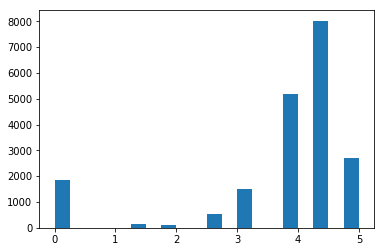

In [5]:
plt.hist(raw_data['rating'],bins=20)
plt.show()

As you can see, there's a large outlier population near the lower end of the scale (bad ratings). Also, the data is not continuous.

In [6]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

Dropping nutrition information, which is missing for some observations.

In [8]:
from sklearn.svm import SVR
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = raw_data.rating
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Note how the above takes a long time. This is because of the number of features we're including (many dummy columns).

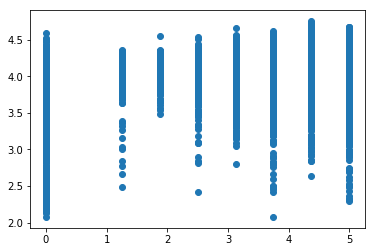

0.03856570651298896 



KeyboardInterrupt: 

In [10]:
plt.scatter(Y, svr.predict(X))
plt.show()

score = svr.score(X, Y)
print(score,'\n')

from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

This model performs extremely poorly. Let's try to do this another way.

### Challenge: Turn this into a classification of low/high scores
The first step is to define what is meant by low or high scores.

In [7]:
len(raw_data[raw_data['rating'] in 0])

TypeError: argument of type 'int' is not iterable

In [8]:
ratings_counts = pd.DataFrame(raw_data['rating'].value_counts())
ratings_counts['score'] = ratings_counts.index
ratings_counts = ratings_counts.reset_index().drop(columns='index')
ratings_counts = ratings_counts.rename(columns={'rating':'occurences','score':'rating'})
ratings_counts

,occurences,rating
0,8019,4.375
1,5169,3.750
2,2719,5.000
3,1836,0.000
4,1489,3.125
5,532,2.500
6,164,1.250
7,124,1.875


In [9]:
ratings_counts[ratings_counts['rating'] >= 4.375].iloc[:,0].sum() / ratings_counts.iloc[:,0].sum()

0.5355076800319171

Ratings with equal to or above a 4.375 rating account for just over half of the observations, and a common sense understanding of ratings makes this a reasonable cutoff point for "high" vs "low" recipe ratings. We'll use a classifier with 1 for high rating, and 0 for low. Now let's try a vanilla model with everything as a starting point.

In [10]:
raw_data['rating_category'] = np.where(raw_data['rating'] >= 4.375,1,0)
raw_data.head(3)

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey,rating_category
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [11]:
from sklearn import svm
clf = svm.SVC()

In [88]:
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = raw_data['rating_category']

cross_val_score(clf,X,Y)

array([1., 1., 1.])

The model is amazingly accurate, but let's do feature selection since this took so long to run and we only want to use ~30 features. First, so the model is generalizable and we can use only a few features, let's get rid of ones that are too uncommon to be useful.

In [12]:
counts = raw_data[raw_data.drop(['rating','rating_category','title','calories', 'protein', 'fat', 'sodium'],axis=1).columns].sum()

In [13]:
counts.describe()

count     674.000000
mean      362.885757
std       975.743648
min         1.000000
25%        10.000000
50%        69.000000
75%       272.500000
max      9355.000000
dtype: float64

For the sake of generalization, I think we should only stick with values that occur pretty often, so let's pick the 50th percentile of >= 69 as a cutoff.

In [14]:
common_vars = counts[counts >= 69]
common_vars_names = list(common_vars.index.values)

In [15]:
common_vars_names

['advance prep required',
 'alcoholic',
 'almond',
 'anise',
 'anniversary',
 'appetizer',
 'apple',
 'apricot',
 'artichoke',
 'arugula',
 'asparagus',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'basil',
 'bass',
 'bean',
 'beef',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'birthday',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bon appétit',
 'bourbon',
 'braise',
 'brandy',
 'bread',
 'breakfast',
 'broccoli',
 'broil',
 'brunch',
 'buffet',
 'butter',
 'buttermilk',
 'butternut squash',
 'cabbage',
 'cake',
 'california',
 'candy',
 'capers',
 'carrot',
 'casserole/gratin',
 'cauliflower',
 'celery',
 'champagne',
 'chard',
 'cheddar',
 'cheese',
 'cherry',
 'chestnut',
 'chicken',
 'chickpea',
 'chile pepper',
 'chill',
 'chive',
 'chocolate',
 'christmas',
 'christmas eve',
 'cilantro',
 'cinco de mayo',
 'cinnamon',
 'citrus',
 'clam',
 'clove',
 'cocktail',
 'cocktail party',
 'coconut'

In [16]:
common_vars_df = raw_data.loc[:,common_vars_names]
common_vars_df[['rating','rating_category']] = raw_data[['rating','rating_category']]
common_vars_df.head()

,advance prep required,alcoholic,almond,anise,anniversary,appetizer,apple,apricot,artichoke,arugula,...,wheat/gluten-free,white wine,wine,winter,wok,yogurt,zucchini,turkey,rating,rating_category
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.500,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.375,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.750,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.125,0


Now let's write some code to loop through and find the chi-squared value for whether not rating category is high or low based on the presence of each common variable.

In [17]:
from scipy import stats
chi_sq = []

for item in common_vars_df.drop(['rating','rating_category'],axis=1).columns:
    rating_cat_crosstab = pd.crosstab(columns=common_vars_df['rating_category'],index=common_vars_df[item])
    chi = stats.chisquare(rating_cat_crosstab,axis=None)
    chi = chi[0]
    chi_sq.append(chi)

In [18]:
chi_df = pd.DataFrame({'var':common_vars_df.drop(['rating','rating_category'],axis=1).columns,'chi_sq':chi_sq})
chi_df.sort_values(by='chi_sq',ascending=False).head(30)

,chi_sq,var
83,19984.670656,cookie
164,19978.917614,legume
134,19974.096150,grape
246,19965.312986,punch
44,19962.464393,buttermilk
328,19961.684421,watermelon
60,19958.776780,chestnut
21,19958.400160,beef tenderloin
49,19956.799122,candy
121,19956.581688,fortified wine


In [19]:
top_vars = list(chi_df.sort_values(by='chi_sq',ascending=False).head(30).loc[:,'var'])
top_var_df = common_vars_df.loc[:,top_vars]
top_var_df[['rating','rating_category']] = common_vars_df.copy()[['rating','rating_category']]

In [20]:
top_var_df.shape

(20052, 32)

In [23]:
X = top_var_df.drop(['rating', 'rating_category'], 1)
Y = top_var_df['rating_category']

cross_val_score(clf,X,Y)

array([0.53836948, 0.53650509, 0.53778243])

Not great, but not as bad as the regression.

In [24]:
common_vars = counts[counts >= 100]
common_vars_names = list(common_vars.index.values)

In [25]:
common_vars_df = raw_data.loc[:,common_vars_names]
common_vars_df[['rating','rating_category']] = raw_data[['rating','rating_category']]

chi_sq = []

for item in common_vars_df.drop(['rating','rating_category'],axis=1).columns:
    rating_cat_crosstab = pd.crosstab(columns=common_vars_df['rating_category'],index=common_vars_df[item])
    chi = stats.chisquare(rating_cat_crosstab,axis=None)
    chi = chi[0]
    chi_sq.append(chi)
    
chi_df = pd.DataFrame({'var':common_vars_df.drop(['rating','rating_category'],axis=1).columns,'chi_sq':chi_sq})
chi_df.sort_values(by='chi_sq',ascending=False).head(30)

top_vars = list(chi_df.sort_values(by='chi_sq',ascending=False).head(30).loc[:,'var'])
top_var_df = common_vars_df.loc[:,top_vars]
top_var_df[['rating','rating_category']] = common_vars_df.copy()[['rating','rating_category']]

X = top_var_df.drop(['rating', 'rating_category'], 1)
Y = top_var_df['rating_category']

cross_val_score(clf,X,Y)

array([0.54285714, 0.54383603, 0.5470597 ])

We see marginal improvements when we mess with the keyword occurrences threshold. Let's see how it works when we add back the nutritional data instead of the final 4 keywords (for a total of 30 still).

In [26]:
new_top_vars = top_vars[:-4]
new_top_var_df = common_vars_df.loc[:,new_top_vars]
new_top_var_df[['rating','rating_category','calories', 'protein', 'fat', 'sodium']] = raw_data.copy()[['rating','rating_category','calories', 'protein', 'fat', 'sodium']]
new_top_var_df = new_top_var_df.dropna(axis=0)


X = new_top_var_df.drop(['rating', 'rating_category'], 1)
Y = new_top_var_df['rating_category']

cross_val_score(clf,X,Y)

array([0.59625567, 0.60041604, 0.6096823 ])

Better, but still not great. To discuss with Vincent!